<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math
from tqdm import tqdm

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

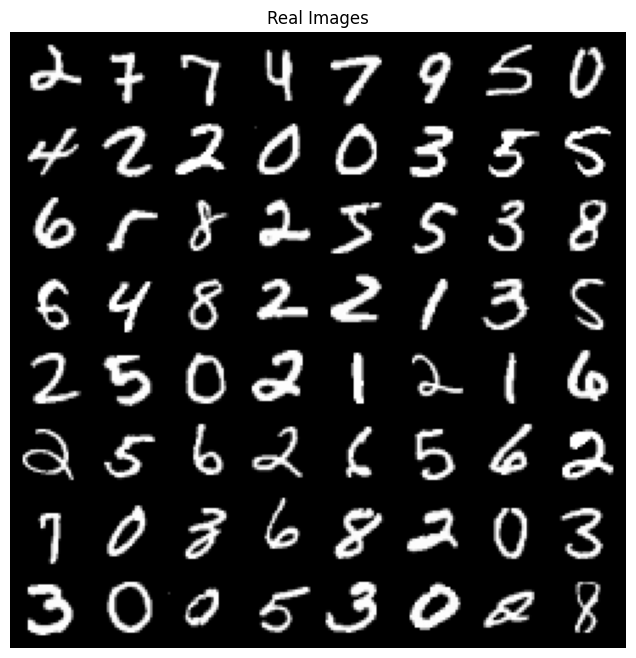

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

In [ ]:
train_dataset[0][0].shape # we have 1 channel and 28*28 dim

torch.Size([1, 28, 28])

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

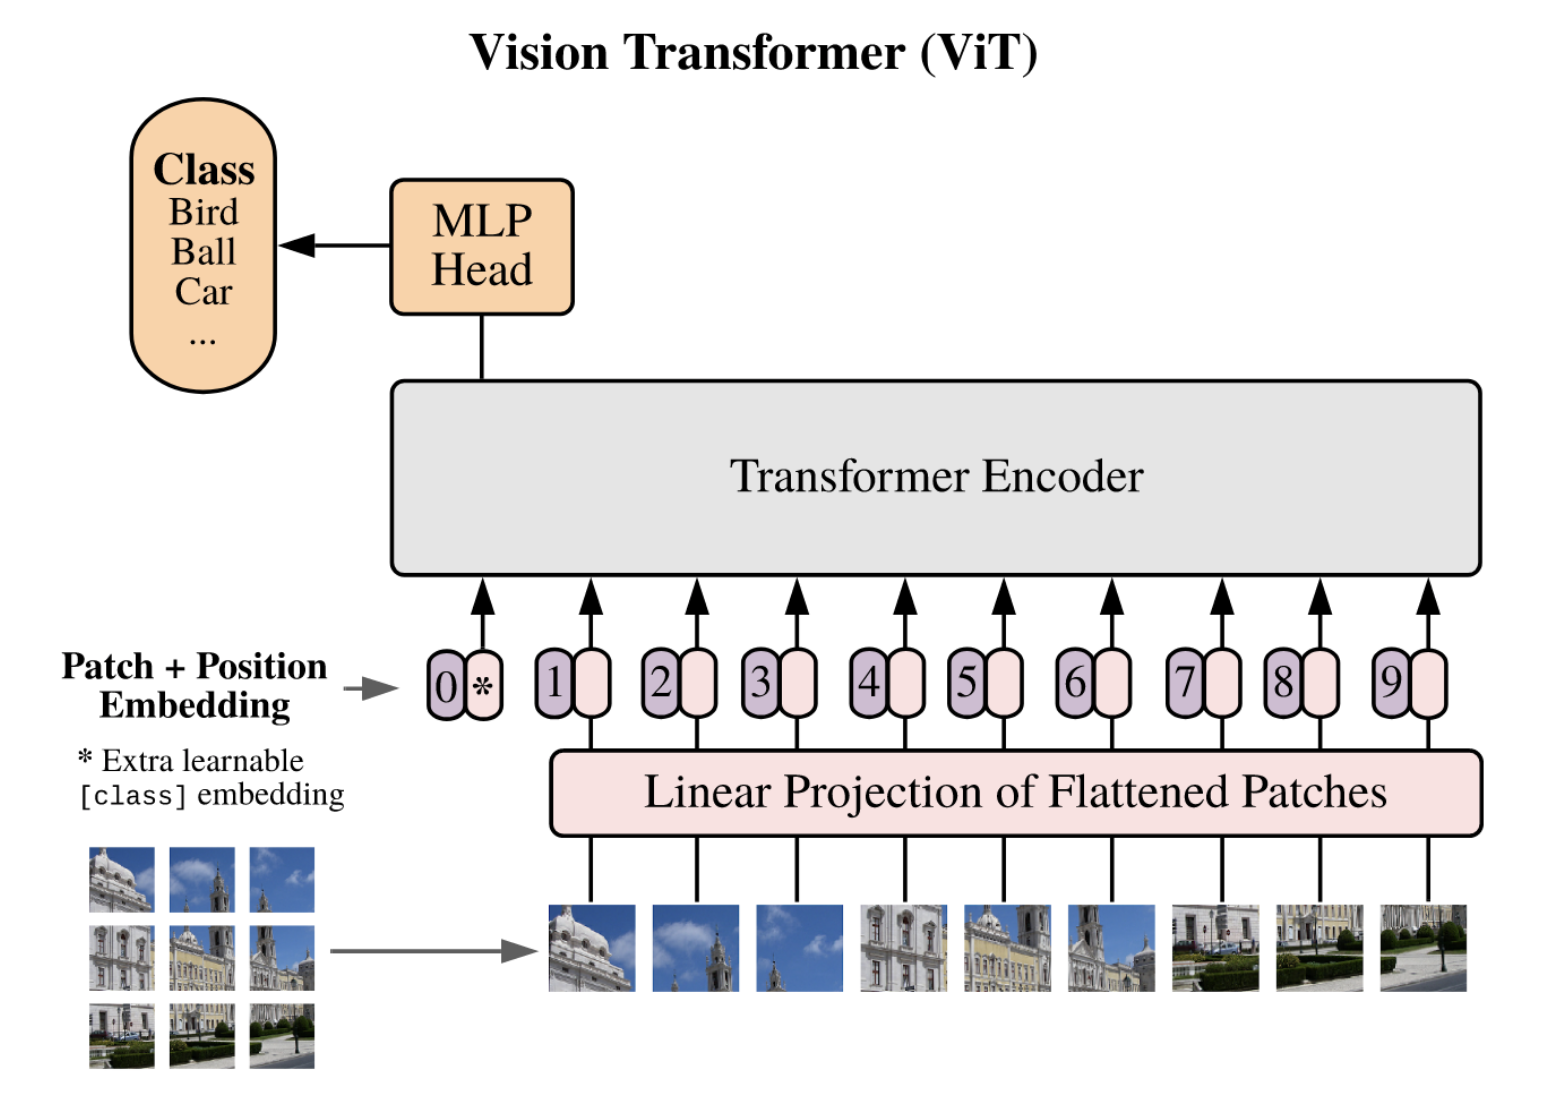

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.in_chan = in_chan # nb channels (by default it's a grey scale)
    self.patch_size = patch_size
    self.embed_dim = embed_dim
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size) # important to have stride=patch_size pour ne pas overlap (ainsi avoir un patch = une valeur; avoir un vecteur de la taille des filters)

  def forward(self, x):
    x = self.projection(x)

    """
    B : batch size
    C : embed_dim == nb filters
    H : nb patches en hauteur
    W : nb patches en largeur
    """
    B, C, H, W = x.shape
    x = x.view(B, C, -1) # reshape to  B, C, N (flatten H,W to N)
    x = x.permute(0, 2, 1) # reshape to B, N, C
    # x.shape() -> B, N, C # == (batch_size, nb_tokens, embedding_dim)
    return x


In [ ]:
# Test
PatchEmbed()(torch.randn(32, 1, 28, 28)).size()

torch.Size([32, 16, 128])

# Transformer encoder

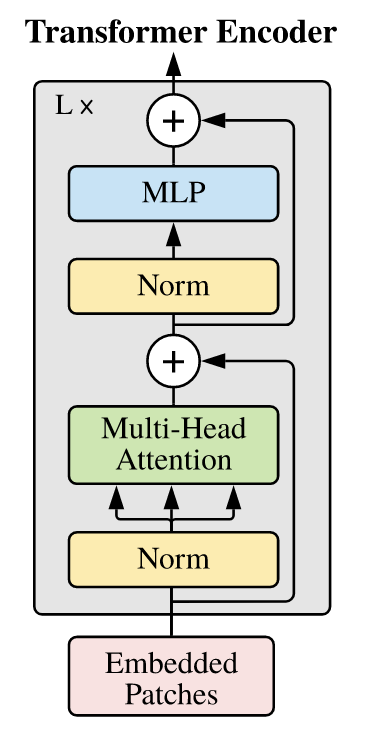

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.in_features = in_features
    self.hid_features = hid_features

    self.mlp = nn.Sequential(
        nn.Linear(self.in_features, self.hid_features),
        nn.GELU(),
        nn.Linear(self.hid_features, self.in_features))


  def forward(self, x):
    x = self.mlp(x)
    return x


MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()

    self.scale = embed_dim ** -0.5

    self.d_q = embed_dim
    self.d_k = embed_dim
    self.d_v = embed_dim

    self.W_q = nn.Linear(embed_dim, self.d_q, bias=False)
    self.W_k = nn.Linear(embed_dim, self.d_k, bias=False)
    self.W_v = nn.Linear(embed_dim, self.d_v, bias=False)

  def forward(self, x):
    B, N, C = x.shape

    # TODO: compute the Q, K, V
    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)


    # TODO: compute the attention matrix using Q and K
    attention = q @ k.transpose(-2,-1) * self.scale

    # TODO: compute the final version using the attention,
    # V, and the final projection
    x = F.softmax(attention, dim=-1) @ v
    return x


SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [ ]:
class MultiHeadsSelfAttention(nn.Module):

  def __init__(self, embed_dim, num_heads = 8):
    super().__init__()

    head_dim = embed_dim // num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.d_q = embed_dim
    self.d_k = embed_dim
    self.d_v = embed_dim

    self.W_q = nn.Linear(embed_dim, self.d_q, bias=False)
    self.W_k = nn.Linear(embed_dim, self.d_k, bias=False)
    self.W_v = nn.Linear(embed_dim, self.d_v, bias=False)

    self.projection = nn.Linear(embed_dim, embed_dim, bias=False)

  def forward(self, x):
    B, N, C = x.shape

    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)

    # You need to reshape and permute dimension in a certain manner so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.

    q = q.view(B, N, self.num_heads, C // self.num_heads). permute(0, 2, 1, 3) # shape : (B, N, num_heads, head_dim)
    k = k.view(B, N, self.num_heads, C // self.num_heads). permute(0, 2, 1, 3) # shape : (B, N, num_heads, head_dim)
    v = v.view(B, N, self.num_heads, C // self.num_heads). permute(0, 2, 1, 3) # shape : (B, N, num_heads, head_dim)

    # TODO: compute the attention matrix
    attention_scores = torch.matmul(q, k.permute(0, 1, 3, 2)) * self.scale # shape : (B, num_heads, N, N)
    attention = F.softmax(attention_scores, dim=-1) # shape : (B, num_heads, N, N)
    output = torch.matmul(attention, v) # shape : (B, num_heads, N, head_dim)

    # Concatenation
    output = output.permute(0, 2, 1, 3).contiguous().view(B, N, C)

    # Projection

    x = self.projection(output)

    return x


MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

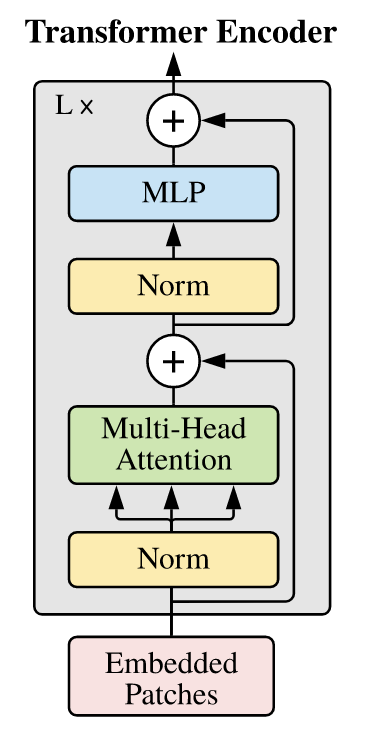

In [ ]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()

    self.norm = nn.LayerNorm(embed_dim)
    self.mha = MultiHeadsSelfAttention(embed_dim, num_heads)
    self.mlp = MLP(embed_dim, embed_dim * mlp_ratio)

  def forward(self, x):

    x_norm = self.norm(x)
    attention = self.mha(x_norm)
    x_attention = x + attention

    x_attention_norm = self.norm(x_attention)
    output = self.mlp(x_attention_norm) + x_attention

    return output

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\
- Explain whay is the the positional embedding (PE) and why it is important? \\

For PE, you can use a sinusoidal encoding (see below), or fully learned.


### Sinusoidal PE


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed =  get_positional_embeddings(num_patches + 1, embed_dim)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, nb_classes)

  def forward(self, x):

    x = self.patch_embed(x) ## image to patches

    ## concatenating class token
    batch_size = x.size(0)
    x = torch.cat((self.class_token.repeat(batch_size, 1, 1), x), dim=1)

    ## adding positional embedding
    x += self.pos_embed

    ## forward in the transformer
    x = self.blocks(x)

    ## CLS token
    x = x[:,0,:]

    ## Normalize the output
    x = self.norm(x)

    output = self.head(x) ## classification output

    return output


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [ ]:
########################################### SAB
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()
model.pos_embed = model.pos_embed.cuda() #pos_embed is not a nn.Module so we need to move it to cuda manually

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")


--- Epoch 0 ---
Train loss: 0.7702896569583462
--- Epoch 1 ---
Train loss: 0.2007553057788786
--- Epoch 2 ---
Train loss: 0.14705960025220538
--- Epoch 3 ---
Train loss: 0.12225878897951102
--- Epoch 4 ---
Train loss: 0.10355235547272128
--- Epoch 5 ---
Train loss: 0.09530245258546333
--- Epoch 6 ---
Train loss: 0.08195282060351135
--- Epoch 7 ---
Train loss: 0.07407490445424054
--- Epoch 8 ---
Train loss: 0.06786391394995232
--- Epoch 9 ---
Train loss: 0.06271516107447715
Test accuracy: 97.41


# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [ ]:
def main(embed_dim, patch_size, nb_blocks, epochs):

    model = ViT(embed_dim, nb_blocks, patch_size).cuda()
    model.pos_embed = model.pos_embed.cuda()
    opt = torch.optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):

        # Boucle d'entraînement
        train_loss = 0.
        total_train = 0
        correct_train = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            opt.zero_grad()
            yhat = model(x)

            loss = F.cross_entropy(yhat, y)
            loss.backward()
            opt.step()

            # Traçage de la loss et accuracy
            train_loss += loss.item()
            _, predicted = yhat.max(1)
            total_train += y.size(0)
            correct_train += predicted.eq(y).sum().item()



        # Boucle d'évaluation
        test_loss = 0.
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()
                yhat = model(x)
                loss = F.cross_entropy(yhat, y)

                # Traçage de la loss et accuracy
                test_loss += loss.item()
                _, predicted = yhat.max(1)
                total_test += y.size(0)
                correct_test += predicted.eq(y).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracy = 100 * correct_test / total_test
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        train_losses.append(train_loss / len(train_loader))

    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies
    }


Varier la dimension d'embedding

Training with embed_dim=32


100%|██████████| 10/10 [01:49<00:00, 10.94s/it]


Training with embed_dim=64


100%|██████████| 10/10 [01:51<00:00, 11.20s/it]


Training with embed_dim=128


100%|██████████| 10/10 [02:01<00:00, 12.17s/it]


Training with embed_dim=256


100%|██████████| 10/10 [02:04<00:00, 12.49s/it]


Training with embed_dim=512


100%|██████████| 10/10 [03:13<00:00, 19.37s/it]


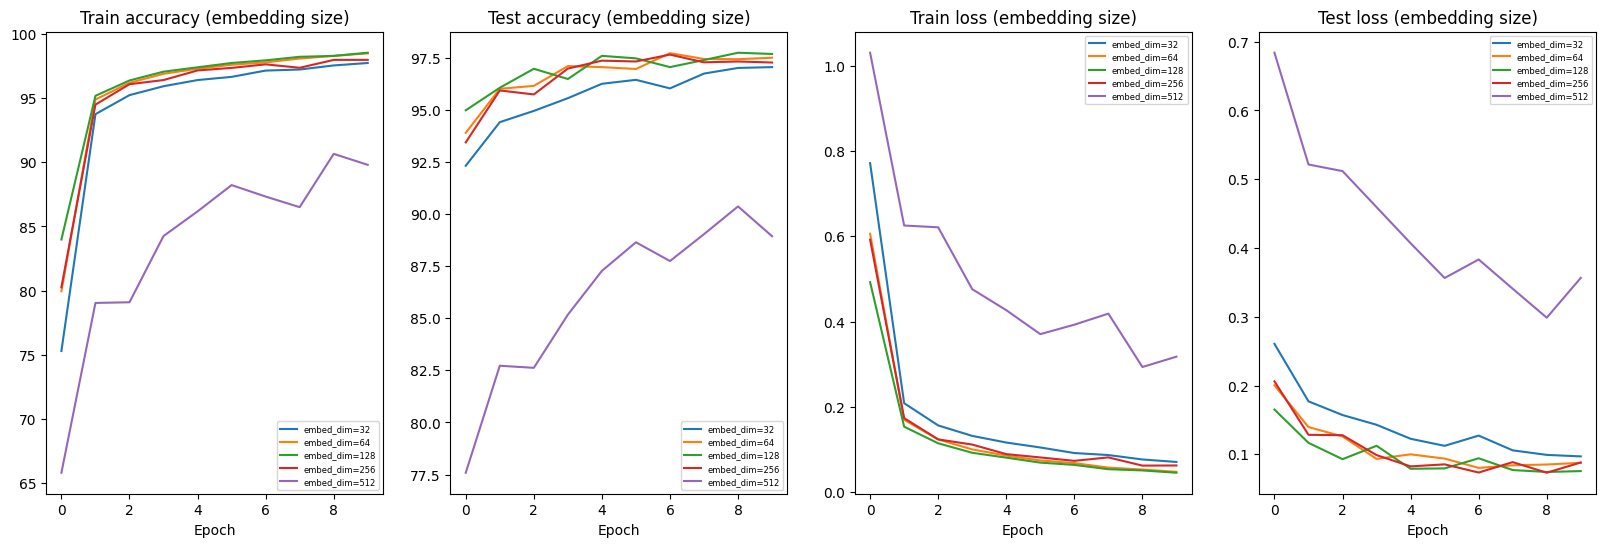

In [ ]:
embed_dim_values = [32, 64, 128, 256, 512]
patch_size = 7
nb_blocks = 2
epochs = 10

results_dict = {
    "train_losses": [],
    "test_losses": [],
    "train_accuracies": [],
    "test_accuracies": []
}


for embed_dim in embed_dim_values:
    print(f"Training with embed_dim={embed_dim}")
    results = main(embed_dim, patch_size, nb_blocks, epochs)


    results_dict["train_losses"].append(results["train_losses"])
    results_dict["test_losses"].append(results["test_losses"])
    results_dict["train_accuracies"].append(results["train_accuracies"])
    results_dict["test_accuracies"].append(results["test_accuracies"])

#Plots
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.title('Train accuracy (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["train_accuracies"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 2)
plt.title('Test accuracy (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["test_accuracies"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 3)
plt.title('Train loss (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["train_losses"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 4)
plt.title('Test loss (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["test_losses"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.show()

**eng:** The optimal embedding size in our case is between 64 and 128 dimensions. The further we stray from these values, the worse the performances. Higher values lead clearly to bad results, whether in terms of loss and accuracy or with regards to the execution time which is highly increased (33% increase from 128 or 256 to 512), showing that adding more information to the inputs does not necessarily mean useful features learned by the model. For the lower values, we can imagine that it leads to over simplifying the information by trying to synthesize it withing a small number of dimensions.

**fr:** Pour les valeurs inférieures à 128, augmenter embed_dim améliore les résultats. Par contre, des valeurs supérieures à ce seuil amènent clairement une perte de performances, que ce soit en termes de loss et d'accuracy, mais aussi au niveau du temps d'exécution qui est supérieur de 33% pour 512 dimensions.

Varier la taille du patch

Training with embed_dim=32, patch_size=2


100%|██████████| 10/10 [03:08<00:00, 18.84s/it]


Training with embed_dim=32, patch_size=4


100%|██████████| 10/10 [01:48<00:00, 10.82s/it]


Training with embed_dim=32, patch_size=7


100%|██████████| 10/10 [01:43<00:00, 10.37s/it]


Training with embed_dim=32, patch_size=14


100%|██████████| 10/10 [01:43<00:00, 10.36s/it]


Training with embed_dim=32, patch_size=28


100%|██████████| 10/10 [01:43<00:00, 10.38s/it]


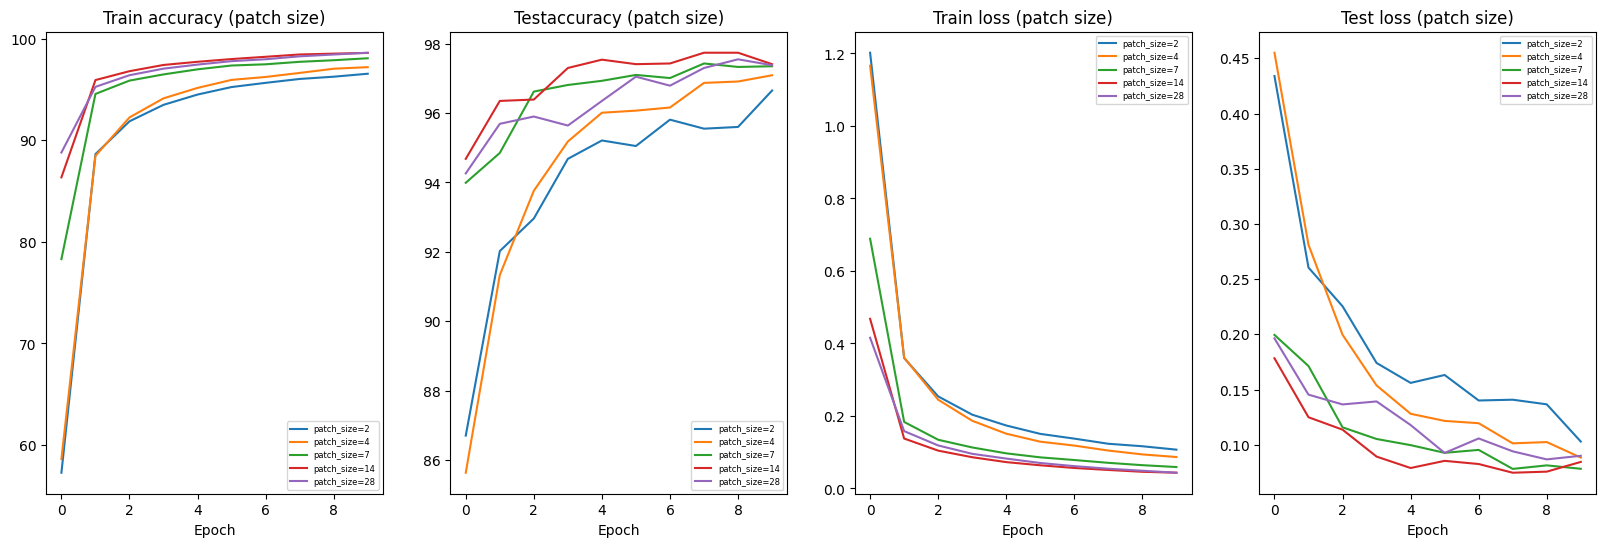

In [ ]:
patch_size_values = [2,4,7, 14, 28]
embed_dim = 32
nb_blocks = 2
epochs = 10

results_dict = {
    "train_losses": [],
    "test_losses": [],
    "train_accuracies": [],
    "test_accuracies": []
}

for patch_size in patch_size_values:
    print(f"Training with embed_dim={embed_dim}, patch_size={patch_size}")
    results = main(embed_dim, patch_size, nb_blocks, epochs)

    results_dict["train_losses"].append(results["train_losses"])
    results_dict["test_losses"].append(results["test_losses"])
    results_dict["train_accuracies"].append(results["train_accuracies"])
    results_dict["test_accuracies"].append(results["test_accuracies"])

# Plots
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.title('Train accuracy (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["train_accuracies"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 2)
plt.title('Test accuracy (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["test_accuracies"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 3)
plt.title('Train loss (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["train_losses"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 4)
plt.title('Test loss (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["test_losses"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.show()

**eng:** The optimal patch size is the one that is most able to isolate the structural units within the image.
Thus, a patch too small contains too elemental informations, and not enough context in order to identify the objects of the image. On the other hand, a patch too big will combine heterogenous structures, which prevents the model from recognizing the structural units.
In the first case, self-attention will detect a high similarity between a large number of patches which wouldn't be discriminative for the classification. The the second, it is harder to find a similarity between the patches because of the added complexity of having different structure within the same patch.

**fr:** La taille de patch idéale est celle qui arrive le mieux à isoler les "unités" structurelles dans l'image.
De ce fait, un patch trop petit aura une granularité trop élémentaire et ne contiendra pas assez de contexte afin d'identifier les structures. D'autre part, un patch trop grand va mélanger des structures étrangères ce qui va empêcher le modèle de reconnaître les unités structurelles.
Dans le premier cas, la self-attention peut retourner une grande similarité entre plusieurs patchs, ce qui ne serait pas discriminant. Dans le deuxième, la découverte de similarités entre les patchs est rendue difficile par la trop grande complexité des différents patchs.

Varier le nombre de blocks Transformer

Training with embed_dim=32, patch_size=28, nb_blocks = 2


100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


Training with embed_dim=32, patch_size=28, nb_blocks = 6


100%|██████████| 10/10 [02:22<00:00, 14.21s/it]


Training with embed_dim=32, patch_size=28, nb_blocks = 10


100%|██████████| 10/10 [02:59<00:00, 17.98s/it]


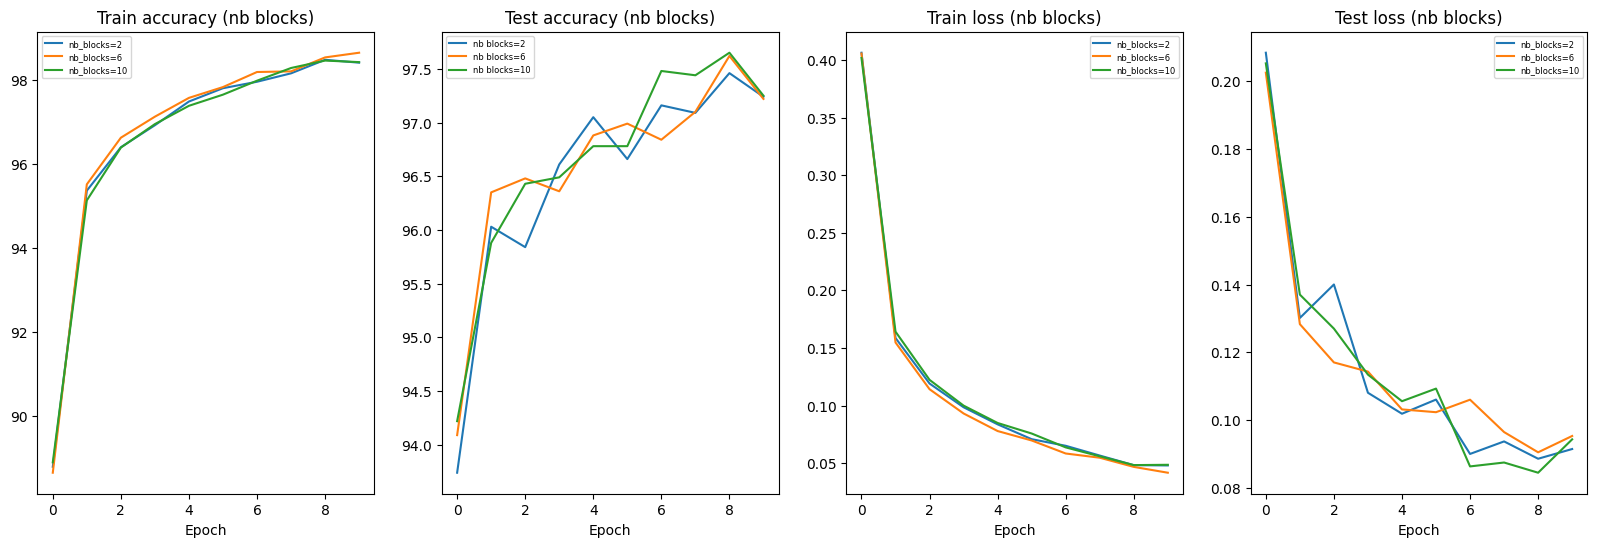

In [ ]:
nb_blocks_values = [2,6,10]
patch_sizes = 2
embed_dim = 32
epochs = 10

results_dict = {
    "train_losses": [],
    "test_losses": [],
    "train_accuracies": [],
    "test_accuracies": []
}


for nb_blocks in nb_blocks_values:
    print(f"Training with embed_dim={embed_dim}, patch_size={patch_size}, nb_blocks = {nb_blocks}")
    results = main(embed_dim, patch_size, nb_blocks, epochs)


    results_dict["train_losses"].append(results["train_losses"])
    results_dict["test_losses"].append(results["test_losses"])
    results_dict["train_accuracies"].append(results["train_accuracies"])
    results_dict["test_accuracies"].append(results["test_accuracies"])

# Plots
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.title('Train accuracy (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["train_accuracies"][i], label=f"nb_blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 2)
plt.title('Test accuracy (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["test_accuracies"][i], label=f"nb blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 3)
plt.title('Train loss (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["train_losses"][i], label=f"nb_blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 4)
plt.title('Test loss (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["test_losses"][i], label=f"nb_blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.show()

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [ ]:
!pip install timm

a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [ ]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=False).cuda()
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
x = torch.randn(32, 1, 28, 28)
# ViT a été entraîné sur imageNet (3 canaux de 224*224). Il faut donc rajouter les canaux manquants (en dupliquant l'actuel) et...
x = x.repeat(1, 3, 1, 1)
# ...Redimensionner les images à (224, 224) en utilisant une interpolation bilinéaire.
x = F.interpolate(x, size=(224, 224), mode="bilinear").cuda()

model(x).shape

torch.Size([32, 1000])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [ ]:
# Charger le modèle avec des poids pré-entraînés et ajuster les paramètres
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=10).cuda()

In [ ]:
# Configurer les transformations pour adapter la taille de l'image
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
x = torch.randn(32, 1, 28, 28)
x = x.repeat(1, 3, 1, 1)
x = transform(x).cuda()
model(x).shape

torch.Size([32, 10])

c) redo the training with the pretrained ViT-S





c) redo the training but with the ViT-S pretrained on ImageNet

In [ ]:
torch.cuda.empty_cache()

In [ ]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0
  #config = resolve_data_config({}, model=model) prend trop de mémoire
  #transform = create_transform(**config)
  for x, y in tqdm(loader):
    x, y = x.cuda(), y.cuda()
    #x = None # adapt number of channels to fit in ViT
    x = x.repeat(1, 3, 1, 1)
    #x = transform(x).cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

Faire:
config = resolve_data_config({}, model=model)

transform = create_transform(**config)

Prend trop de mémoire


In [ ]:
def main(model, epochs=10):
  model.cuda()
  model.train()

  opt = torch.optim.Adam(model.parameters())
  train_losses = []
  accuracies = []

  for epoch in range(epochs):
    train_loss = 0.
    for x, y in tqdm(train_loader):
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      x = x.repeat(1, 3, 1, 1)

      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()
    train_losses.append(train_loss)
    acc = eval_model(model, test_loader, num_channels=3)
    accuracies.append(acc)
    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train_loader)}")

  print(f"Test accuracy: {acc}")
  return train_losses, accuracies


Comparaison des deux modèles em même temps

In [ ]:
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=10, img_size=28).cuda()

In [ ]:
train_losses, accuracies = main(model, 10)

100%|██████████| 79/79 [00:02<00:00, 32.15it/s]


--- Epoch 0 ---
Train loss: 1.5348560900322155


100%|██████████| 79/79 [00:02<00:00, 35.47it/s]


--- Epoch 1 ---
Train loss: 0.675282830813292


100%|██████████| 79/79 [00:02<00:00, 35.08it/s]


--- Epoch 2 ---
Train loss: 0.5351340688113719


100%|██████████| 79/79 [00:02<00:00, 35.34it/s]


--- Epoch 3 ---
Train loss: 0.49221040800944577


100%|██████████| 79/79 [00:02<00:00, 30.30it/s]


--- Epoch 4 ---
Train loss: 0.45428509848204246


100%|██████████| 79/79 [00:02<00:00, 34.93it/s]


--- Epoch 5 ---
Train loss: 0.42530820892055404


100%|██████████| 79/79 [00:02<00:00, 35.08it/s]


--- Epoch 6 ---
Train loss: 0.403330282711271


100%|██████████| 79/79 [00:02<00:00, 35.08it/s]


--- Epoch 7 ---
Train loss: 0.39213844059881114


100%|██████████| 79/79 [00:02<00:00, 29.74it/s]


--- Epoch 8 ---
Train loss: 0.36825553456476245


100%|██████████| 79/79 [00:02<00:00, 35.42it/s]

--- Epoch 9 ---
Train loss: 0.35575701629937584
Test accuracy: 88.45


In [ ]:
model_pt = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=10, img_size=28).cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
train_losses_pt, accuracies_pt = main(model_pt, 10)

100%|██████████| 79/79 [00:02<00:00, 33.02it/s]


--- Epoch 0 ---
Train loss: 1.2154744880031676


100%|██████████| 79/79 [00:02<00:00, 34.38it/s]


--- Epoch 1 ---
Train loss: 0.5880803847109585


100%|██████████| 79/79 [00:03<00:00, 20.29it/s]


--- Epoch 2 ---
Train loss: 0.4799405105713842


100%|██████████| 79/79 [00:02<00:00, 34.79it/s]


--- Epoch 3 ---
Train loss: 0.4259413092502399


100%|██████████| 79/79 [00:02<00:00, 35.05it/s]


--- Epoch 4 ---
Train loss: 0.39399800438489485


100%|██████████| 79/79 [00:02<00:00, 33.61it/s]


--- Epoch 5 ---
Train loss: 0.37837898585079577


100%|██████████| 79/79 [00:02<00:00, 35.24it/s]


--- Epoch 6 ---
Train loss: 0.3631888605129998


100%|██████████| 79/79 [00:02<00:00, 35.28it/s]


--- Epoch 7 ---
Train loss: 0.3637987109326096


100%|██████████| 79/79 [00:02<00:00, 30.96it/s]


--- Epoch 8 ---
Train loss: 0.34560173975506314


100%|██████████| 79/79 [00:02<00:00, 35.79it/s]

--- Epoch 9 ---
Train loss: 0.34283633565089344
Test accuracy: 88.27


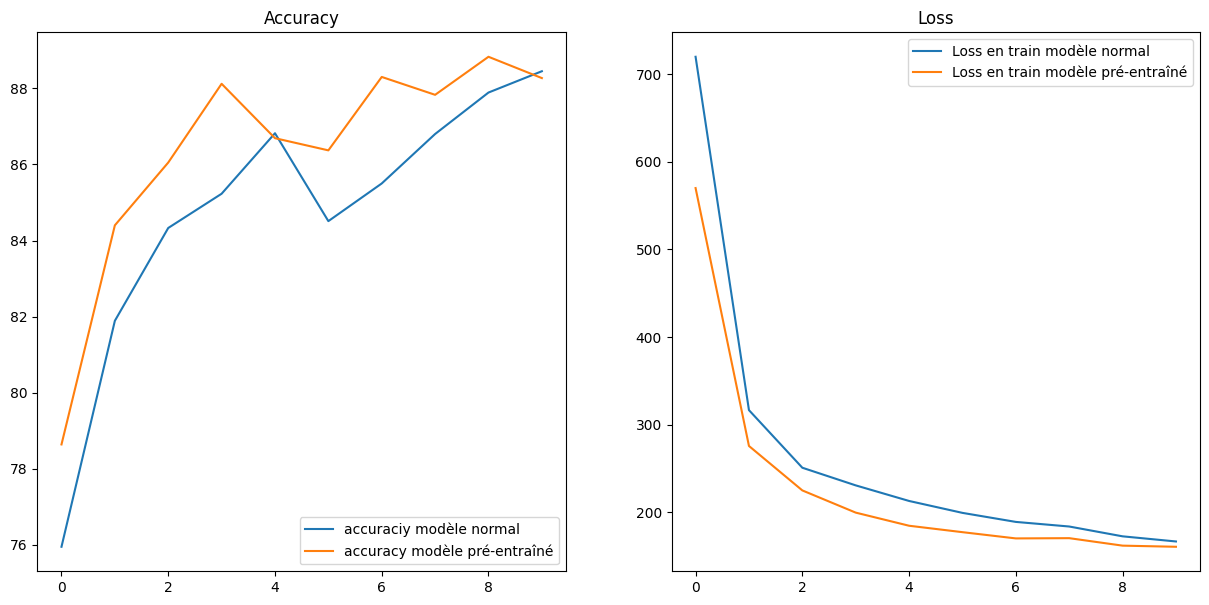

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[0].plot(np.arange(len(accuracies)), accuracies, label="accuraciy modèle normal")
axs[0].plot(np.arange(len(accuracies_pt)), accuracies_pt, label="accuracy modèle pré-entraîné")
axs[0].set_title("Accuracy")
axs[0].legend()

axs[1].plot(np.arange(len(train_losses)), train_losses, label="Loss en train modèle normal")
axs[1].plot(np.arange(len(train_losses_pt)), train_losses_pt, label="Loss en train modèle pré-entraîné")
axs[1].set_title("Loss")
axs[1].legend()

plt.show()


**The loss is lower and accuracy is higher with the pre-trained model. It is important to note that we executed for a limited number of epochs (10), and if the training kept going on, we would have seen a clearer convergence.**


d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.

>> In the Report